### Experiment Protocols

Subjects rested on a tilt table with foot support and subsequently underwent a series of six changes in posture: 
- Two stand-ups, (= 6 min)
- Two rapid HUTs (75◦ HUT over 2 secs), and (= 6 min)
- Two slow HUTs (75◦ HUT over 50 secs) (= 6 min)
- Each lasting for three minutes and separated by five minutes in the resting supine position.
- The sequence of six interventions was randomized for each subject.
- At the conclusion of the final intervention, the subject was returned to the horizontal position for a final five minutes of   supine baseline recording.

For six postural changes:
- Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest ( atleast 35 + 18 = 53 min of data)


- The RR interval data is cleaned by removing outliers
- No interpolation

In [1]:
# import libraries

%matplotlib inline
import math
import numpy as np
import pandas as pd

from Laguerre import phi_j, l_j, lagl_j # call laguerre related functions from .py file

import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ECG processing libraries
import scipy.signal 
import peakutils
import heartpy as hp
import wfdb
from wfdb import processing


#### Value of constants

In [2]:
alpha = .2
J = 9
N1 = 2
N2 = 7
W_n = 90

num_parameters = 10
forgetting_factor = .98

# Values taken from related paper
coeff_S = [39.2343, 10.1963, -5.9242] 
coeff_P = [28.4875, -17.3627, 5.8798, 12.0628, 5.6408, -7.0664, -5.6779, -3.9474]


#### Define functions

In [3]:
# define function to identify outliers using Interquartile menthod
def find_outliers(df, thresh):
    q1 = np.quantile(df, 0.25)
    q3 = np.quantile(df, 0.75)
    IQR=q3-q1
    outliers = df[(df < (q1 - thresh*IQR)) | (df > (q3 + thresh*IQR))]
    return outliers

In [4]:
def normalize(x):
    x = x - np.mean(x)
    return x/np.std(x)

#### Read one ECG recording in wfdb format

In [5]:
# Plot the signals, and show the data.
record = wfdb.rdrecord('changes-in-postureData/12726') 
#wfdb.plot_wfdb(record=record, title='Record 12726 from PhysioNet Postural Data', figsize=(12,10)) 
display(record.__dict__)

{'record_name': '12726',
 'n_sig': 3,
 'fs': 250,
 'counter_freq': 24000.0,
 'base_counter': None,
 'sig_len': 825000,
 'base_time': datetime.time(15, 8, 24),
 'base_date': None,
 'comments': ['<age>: 28  <sex>: M  <Height>: 170  <Weight>: 64',
  'Produced by xform from record 12726_orig, beginning at 0:0'],
 'sig_name': ['ABP', 'ECG', 'Angle'],
 'p_signal': array([[ 6.24804749e+01, -1.98291120e+00, -4.57587371e-02],
        [ 6.21055920e+01, -1.98962466e+00, -4.57587371e-02],
        [ 6.14807873e+01, -1.97070491e+00, -4.57587371e-02],
        ...,
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01],
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01],
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['12726.dat', '12726.dat', '12726.dat'],
 'fmt': ['16', '16', '16'],
 'samps_per_frame': [1, 1, 1],
 'skew': [None, None, None],
 'byte_offset': [None, None, None],
 'adc_gain': [64.02

In [6]:
#Convert record into dataframe whose index is TimedeltaIndex
record_df = record.to_dataframe()
record_df

,ABP,ECG,Angle
0 days 00:00:00,62.480475,-1.982911,-0.045759
0 days 00:00:00.004000,62.105592,-1.989625,-0.045759
0 days 00:00:00.008000,61.480787,-1.970705,-0.045759
0 days 00:00:00.012000,61.168385,-1.966433,-0.045759
0 days 00:00:00.016000,60.855983,-1.979860,-0.045759
...,...,...,...
0 days 00:54:59.980000,0.812246,0.000610,-0.160156
0 days 00:54:59.984000,0.812246,0.000610,-0.160156
0 days 00:54:59.988000,0.812246,0.000610,-0.160156
0 days 00:54:59.992000,0.812246,0.000610,-0.160156


In [7]:
# ECG data is saved in an array
# ecg_data = record.p_signal[:,1]
ecg_df = pd.DataFrame(record_df.iloc[:,1])
angle_df = pd.DataFrame(record_df.iloc[:,2])


#### Working with ECG data

In [8]:
# ecg_data
ecg_df

,ECG
0 days 00:00:00,-1.982911
0 days 00:00:00.004000,-1.989625
0 days 00:00:00.008000,-1.970705
0 days 00:00:00.012000,-1.966433
0 days 00:00:00.016000,-1.979860
...,...
0 days 00:54:59.980000,0.000610
0 days 00:54:59.984000,0.000610
0 days 00:54:59.988000,0.000610
0 days 00:54:59.992000,0.000610


In [9]:
angle_df.head()

,Angle
0 days 00:00:00,-0.045759
0 days 00:00:00.004000,-0.045759
0 days 00:00:00.008000,-0.045759
0 days 00:00:00.012000,-0.045759
0 days 00:00:00.016000,-0.045759


In [10]:
# using heartpy.process, wd = working_data dict in which results are stored, measures(m): measures dict in which results are stored
wd_band, m_band = hp.process(ecg_df['ECG'], sample_rate = record.fs)


In [11]:
# number of RR peaks
len(wd_band['peaklist'])

3800

#### Find rr interval using 'peaklist' from 'wd'

In [12]:
t = np.arange(0, len(ecg_df))/250

# Finding RR interval
RR = np.diff(t[wd_band["peaklist"]])
print(len(RR))

3799


In [13]:
RR

array([0.988, 1.008, 0.944, ..., 0.996, 1.092, 0.812])

In [14]:
HR = 60/RR

print(HR, len(HR))

[60.72874494 59.52380952 63.55932203 ... 60.24096386 54.94505495
 73.89162562] 3799


In [15]:
print('max HR is', max(HR), ' and min HR is', min(HR))

max HR is 15000.000000354703  and min HR is 7.763975155279551


#### Working with angle_data -- Finding angle value at the peaks

In [16]:
peak_angle = angle_df['Angle'][wd_band['peaklist']].reset_index().drop(columns=['index'])
print(peak_angle)
print(type(peak_angle))

         Angle
0    -0.045759
1    -0.045759
2    -0.045759
3    -0.045759
4    -0.045759
...        ...
3795  0.068638
3796  0.068638
3797  0.068638
3798  0.068638
3799  0.068638

[3800 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


#### Remove outliers from the RR_interval data

In [17]:
time_df = t[wd_band["peaklist"]] #find time points of R-peaks

RR_df = pd.DataFrame(RR, time_df[1:]).reset_index().rename(columns={'index':'beats', 0:'RR'})
RR_df['angle_peaks'] = peak_angle
#RR_df['timestamp_peaks'] = timestamp_peaks
RR_df

,beats,RR,angle_peaks
0,1.232,0.988,-0.045759
1,2.240,1.008,-0.045759
2,3.184,0.944,-0.045759
3,4.168,0.984,-0.045759
4,5.152,0.984,-0.045759
...,...,...,...
3794,3247.488,1.020,0.068638
3795,3248.528,1.040,0.068638
3796,3249.524,0.996,0.068638
3797,3250.616,1.092,0.068638


In [18]:
# Remove outliers from RR_band
outliers = find_outliers(RR_df['RR'], 1.5)
print(outliers, len (outliers))
print('....................')
RR_clean = RR_df.drop(outliers.index).reset_index().drop(columns='index') 
print(RR_clean)



423     0.008
424     1.700
668     0.008
673     3.908
688     0.236
        ...  
3534    1.516
3620    0.008
3622    1.500
3711    0.008
3712    1.656
Name: RR, Length: 232, dtype: float64 232
....................
         beats     RR  angle_peaks
0        1.232  0.988    -0.045759
1        2.240  1.008    -0.045759
2        3.184  0.944    -0.045759
3        4.168  0.984    -0.045759
4        5.152  0.984    -0.045759
...        ...    ...          ...
3562  3247.488  1.020     0.068638
3563  3248.528  1.040     0.068638
3564  3249.524  0.996     0.068638
3565  3250.616  1.092     0.068638
3566  3251.428  0.812     0.068638

[3567 rows x 3 columns]


### Calculating Laguerre polynomial of order j with time-lag (RR_intervals) n, 0<=n<90,  0<=j<=

In [19]:
phi_mat = np.array([[phi_j(n,j, alpha)  for j in range (J)] for n in range(1, W_n)])

### Calculating Laguerre filter output using laguerre polynomials and RR interval at time t=2 in the given window (w_n)

In [20]:
l_j(J,2, RR_clean, W_n, alpha)

array([ 0.57993881, -1.09422957, -0.52913224, -0.00149635,  0.21760091,
        0.24551304,  0.19869593,  0.13873355,  0.08887239])

### Laguerre filter output at all time points

In [21]:
lagj_t = lagl_j(J, RR_clean, W_n, alpha)

#### Convert the laguerre filter output matrix into dataframe

In [22]:
G = [f'l{j}'  for j in range(J)]
lag_df = pd.DataFrame(lagj_t, columns=G)
lag_df['RR'] = RR_clean['RR']


In [23]:
lag_df.shape

(3567, 10)

#### Add a column of constant 

In [24]:
lag_df.insert(0,'const', 1 )
#lag_df

In [25]:
lag_df.iloc[1,:-1]

const    1.000000
l0       0.579939
l1      -1.094230
l2      -0.529132
l3      -0.001496
l4       0.217601
l5       0.245513
l6       0.198696
l7       0.138734
l8       0.088872
Name: 1, dtype: float64

## Recursive Least Square Method implementation

In [26]:
# Initialization
theta = np.zeros((J+1,1))
phi = np.empty((1,J+1))
P = np.eye((J+1))*100

In [27]:
np.expand_dims(phi[0], axis=0).shape


(1, 10)

In [28]:
np.expand_dims(lag_df.iloc[1,:-1], axis=1).shape

(10, 1)

In [29]:
x = np.array([lag_df.iloc[i,:-1] for i in range(len(lag_df))])
x.shape

(3567, 10)

In [30]:
x[0]

array([ 1.        ,  0.3952    , -0.53021644, -0.55328   , -0.38882539,
       -0.23712   , -0.1343215 , -0.0727168 , -0.03817558, -0.01960192])

In [31]:
y = lag_df['RR']
y.shape

(3567,)

### Calculate the indices for widow size 90 and forgetting factor .98

In [32]:
# Implementing RLS algorithm
class RecursiveLeastSquares:
    def __init__(self, num_parameters, forgetting_factor):
        self.num_parameters = num_parameters
        self.forgetting_factor = forgetting_factor
        self.theta = np.zeros((num_parameters,1))
        self.P = np.eye(num_parameters)  # Initial covariance matrix

    def update_params(self, x, y):
        x = np.reshape(x, (self.num_parameters, 1))  # Reshape input vector
        y_hat = np.dot(np.transpose(self.theta), x)  # Predicted output


        # Calculate the gain matrix
        k = np.dot(self.P, x) / (self.forgetting_factor + np.dot(np.dot(np.transpose(x), self.P), x))

        # Update the estimated parameter 
        self.theta = self.theta + np.dot(k, (y - y_hat))

        # Update the covariance matrix
        self.P = (1 / self.forgetting_factor) * (self.P - np.dot(np.dot(k, np.transpose(x)), self.P))

    def get_parameters(self):
        return self.theta

In [33]:
# Create an instance of the RLS estimator
rls_estimator = RecursiveLeastSquares(num_parameters, forgetting_factor)
params_w_100 = []

# Perform recursive parameter estimation
for i in range(W_n, len(lag_df)):
    rls_estimator = RecursiveLeastSquares(num_parameters, forgetting_factor)
    x_w_n = np.array(x[i-W_n:i])
    y_w_n = np.array(y[i-W_n:i])
    [rls_estimator.update_params(x_w_n[j], y_w_n[j]) for j in range(W_n)]
    params_w_100.append(rls_estimator.get_parameters())
    #print(rls_estimator.get_parameters()) #Get the estimated parameters

In [34]:
#reduce the dimension of list elements
params_w_100=np.squeeze(params_w_100)
params_w_100

array([[ 0.34571502,  0.20339073, -0.33268638, ..., -0.01382298,
         0.0083947 ,  0.00729634],
       [ 0.25441143,  0.19370591, -0.36850646, ...,  0.00405184,
         0.01957977,  0.01211662],
       [ 0.19987302,  0.17216624, -0.36047072, ..., -0.03865437,
        -0.00804129,  0.00283673],
       ...,
       [ 0.03955922,  0.13447169, -0.25434195, ...,  0.01729611,
        -0.02647779,  0.04427964],
       [ 0.0400531 ,  0.1319314 , -0.2498952 , ...,  0.01830828,
        -0.02787732,  0.04612428],
       [ 0.03048383,  0.13979321, -0.26158099, ...,  0.00745148,
        -0.03433151,  0.04162126]])

In [35]:
print(len(params_w_100))
print(params_w_100.shape)

3477
(3477, 10)


#### Calculate the indices

In [36]:
SAI = coeff_S[0] + np.sum(coeff_S[1:]*params_w_100[:,1:3], axis=1)
PAI = coeff_P[0] + np.sum(coeff_P[1:7]*params_w_100[:,4:], axis=1)

In [37]:
len(SAI)

3477

In [38]:
peaks,  props= find_peaks(np.round(angle_df.Angle), width=3, height=[73,76], plateau_size = 3)
props

{'plateau_sizes': array([   58, 46864, 49757, 43501, 37002], dtype=int64),
 'left_edges': array([100072, 100133, 250835, 624706, 732443], dtype=int64),
 'right_edges': array([100129, 146996, 300591, 668206, 769444], dtype=int64),
 'peak_heights': array([74., 74., 75., 74., 75.]),
 'prominences': array([74., 74., 75., 74., 75.]),
 'left_bases': array([ 87529,  87529, 250300, 612056, 731983], dtype=int64),
 'right_bases': array([159382, 159382, 301187, 680639, 770021], dtype=int64),
 'widths': array([57691., 57691., 50314., 54405., 37469.]),
 'width_heights': array([37. , 37. , 37.5, 37. , 37.5]),
 'left_ips': array([ 94643. ,  94643. , 250488.5, 619188. , 732169.5]),
 'right_ips': array([152334. , 152334. , 300802.5, 673593. , 769638.5])}

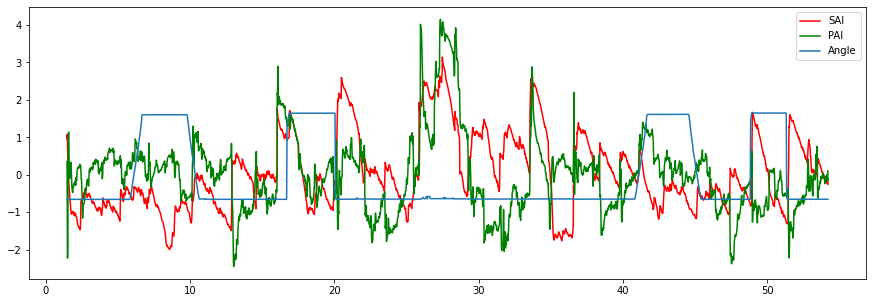

In [39]:
fig, ax = plt.subplots(1,1,figsize = (15,5))
import seaborn as sns

plt.plot(RR_clean['beats'][90:]/60, normalize(SAI), color='red', label='SAI')
plt.plot(RR_clean['beats'][90:]/60, normalize(PAI), color='green', label='PAI')
plt.plot(RR_clean['beats'][90:]/60, normalize(RR_clean['angle_peaks'][90:]), label='angle')

ax.legend(['SAI', 'PAI', 'Angle'])


In [40]:
stats.pearsonr(SAI, RR_clean['angle_peaks'][90:])


(-0.2935748527316747, 4.494465852155045e-70)

In [41]:
stats.pearsonr(PAI, RR_clean['angle_peaks'][90:])

(0.04028891182004305, 0.01751142382855277)

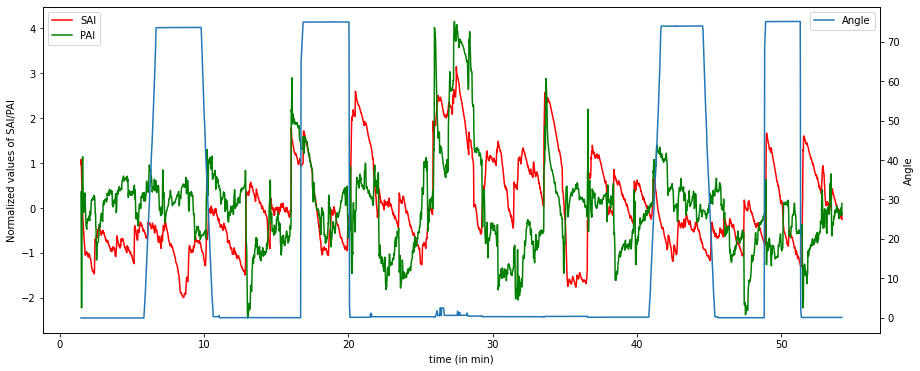

In [42]:
# Instantiate a second axes that shares the same x-axis
fig, ax1 = plt.subplots(1,1, figsize=(15, 6))
ax2 = ax1.twinx()

ax1.plot(RR_clean['beats'][W_n:]/60, normalize(SAI), color='red', label='SAI')
ax1.plot(RR_clean['beats'][W_n:]/60, normalize(PAI), color='green', label='PAI')
ax2.plot(RR_clean['beats'][W_n:]/60, RR_clean['angle_peaks'][W_n:], label='angle')
ax1.set_xlabel("time (in min)")
ax2.set_ylabel("Angle")
ax1.set_ylabel("Normalized values of SAI/PAI")
ax1.legend(['SAI', 'PAI'], loc='upper left')
ax2.legend(['Angle'])